# Quora Questions - Text Classification
Note: this is written in python 2. The only difference between python 2 and 3 in this code is seen in the print statements.

Link to data: https://www.kaggle.com/c/quora-insincere-questions-classification/data

### Background 
We selected a problem in which we determine whether questions asked on Quora are sincere or insincere. Quora is an online platform for users to connect with one another, ask questions, and contribute with insightful responses to unanswered questions with the end goal to spread knowledge. Sincere questions are inquiries about which individuals genuinely want to know an answer or gain information from rather than argue a point or make a statement.  For instance, “What are some sleep hacks and tips?” is deemed as sincere since it is a candid question which is most likely asked by an individual who would like some advice on falling asleep. On the other hand, insincere questions intend to make some sort of a statement and are usually asked not with the intention of receiving a helpful answer/comment. It is often the case that insincere questions target religion, gender, politics, etc. and are constructed in a non-neutral tone, are exaggerated, or use words that attack various groups. For example, "If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?" is classified as insincere since it targets the Black community and is phrased in a demeaning manner. 

The data we used came from a Kaggle competition and is separated into two datasets, training and testing. The training set consists of a list of questions along with their target values (0 for sincere and 1 for insincere). However, the testing data only contains the sample questions without the target values. 

We were all interested in this specific dataset and the classification of questions as sincere or insincere because we are all active users of Quora. Additionally, we understand that reducing unproductive and harmful content online is a challenge for many  tech companies including Quora. This motivated us to gain perspective on the process of moderating online speech. 

After exploring the data, we found that while the length of a question or occurrences of key words might be indicators of one category over the other, we wanted to take a step further and look into more detail of how this process works and what techniques could be used in order to detect the distinctions between the two categories.  

It is important to note that there is some noise in the target values for the given training dataset. We encountered some questions in the training set, which were deemed as insincere, that could be considered sincere. These target values were likely predicted by a machine learning model made by Quora. Lastly, the distribution of questions in the training set should not be taken to accurately represent the distribution of sincere and insincere questions submitted to Quora. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import copy
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

In [2]:
original_train = pd.read_csv('QuoraQuestions/train.csv')
original_test = pd.read_csv('QuoraQuestions/test.csv')

In [3]:
original_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
original_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


## Percentages of the two classes in the data
Two sample types:
* sincere
* insincere

In [5]:
num_sincere = float(len(original_train[original_train['target'] == 0]))
num_insincere = float(len(original_train[original_train['target'] == 1]))
print num_sincere
print num_insincere
print num_sincere / (num_sincere + num_insincere)
print num_insincere / (num_sincere + num_insincere)

1225312.0
80810.0
0.938129822482
0.0618701775179


Evidently, from above we have an unbalanced dataset in which our number of sincere questions grossly out numbers the number of insincere questions.

## Let's examine the data
Specifically, we'll look at a few samples of insincere questions from our training data.

In [6]:
original_train[original_train['target'] == 1].head()['question_text'][30] # definitively insincere

'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?'

In [7]:
original_train[original_train['target'] == 1].head()['question_text'][110] # on the cusp - could be considered insincere bc "blacks" is not necessarily PC

"If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?"

In [8]:
original_train[original_train['target'] == 1].head()['question_text'][114] # lascivious and this is borderline incest

'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?'

In [9]:
original_train[original_train['target'] == 1].head()['question_text'][115] # definitely insincere

'Which races have the smallest penis?'

In [10]:
original_train[original_train['target'] == 1].tail()['question_text'][1306093] # part 2 - incest

'How is it to have intimate relation with your cousin?'

In [11]:
original_train[original_train['target'] == 1].tail()['question_text'][1306099] # racist towards pakistani people

'Do pakis smell of curry and shit?'

In [12]:
original_train[original_train['target'] == 1].tail()['question_text'][1306094] # provocative and trying to make a statement

'Why is it when singers have lyrics about voices in their head, religious people say they hear god and anyone stating they are being targeted by voice to brain technology? Are they called delusional schizo?'

In [13]:
split_train1 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 1]['question_text']))
split_train0 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 0]['question_text']))

## Exploratory Visual Analysis 
We first wanted to gain insight into what our data looks like so that we could get a better idea of how to approach our insincere and sincere question prediction.  When we originally started the project, we didn’t even have a grasp as to what Quora considered insincere so we examined many examples and discovered that almost all the insincere questions could be boiled down to umbrella topics which included: racism, overtly sexual comments, blatant mockery, and political insults.

Another important factor that helped us understand how sensitive our model should be was to look at the ratio of sincere to insincere questions which we later found was roughly 15:1. Further along, we also opted to look at aspects of questions that would help us differentiate between the two categories. We looked at the number of most common first words as well as the count of words in general found in either the sincere and insincere question types. Aside from single word frequencies, we also looked at some common bigrams and trigrams that were common in both categories. Lastly, we graphed out the question lengths of both question types with some interesting results and created word clouds to give some artistic visuals.


### Pie Chart - Percent of Sincere/Insincere Questions

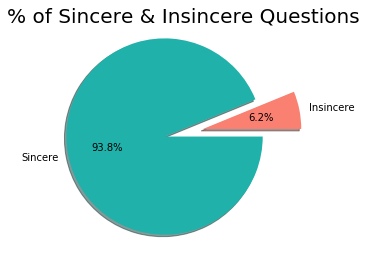

In [14]:
def question_proportion(sizes):
    # Pie-chart for sincere/insincere questions
    labels = 'Insincere', 'Sincere'
    explode = (0.4, 0)
    plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow=True, colors = ['salmon', 'lightseagreen'])
    plt.axis('equal')
    plt.title('% of Sincere & Insincere Questions', fontsize = 20)
    plt.show()
question_proportion(sizes = [num_insincere, num_sincere])

Insincere questions are in the vast minority of our total Quora question pool.  Only about 6% of questions asked were deemed insincere which is a ratio of about 15:1.

### Most Common First Words for Insincere/Sincere Questions

In [15]:
def common_first_words(split_train):
    most_common_words = {} # most common first words of each sincere question
    for question in split_train:
        if question[0] in most_common_words:
            most_common_words[question[0]] += 1
        else:
            most_common_words[question[0]] = 1
    sorted_by_desc = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
    top7 = sorted_by_desc[0:7]
    return [top7[i][0] for i in range(7)],  [top7[i][1] for i in range(7)]

In [16]:
def plot_first_words(top7_words, top7_counts, q_type, c):
    plt.barh(top7_words, top7_counts, color = c)
    plt.title('Most Common First Words and Their Counts', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 13)
    plt.xlabel('# of Questions', fontsize = 13)
    plt.ylabel('First Word', fontsize = 14)
    if q_type == 'Sincere':
        tick_val = [100000, 200000, 300000, 400000]
        tick_lab = ['100k', '200k', '300k', '400k']
    else:
        tick_val = [10000, 20000, 30000, 40000]
        tick_lab = ['10k', '20k', '30k','40k']
    plt.xticks(tick_val,tick_lab)
    plt.legend([q_type + ' Questions'])
    sns.set_style('darkgrid')
    plt.show()

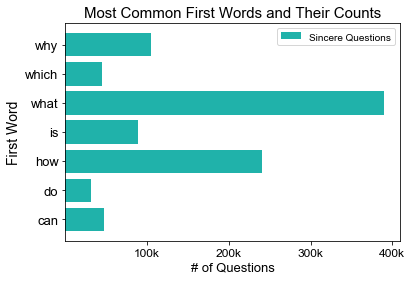

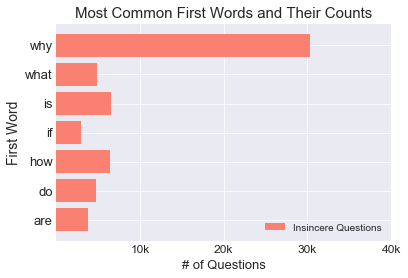

In [17]:
top7_words0, top7_counts0 = common_first_words(split_train0)
top7_words1, top7_counts1 = common_first_words(split_train1)
plot_first_words(top7_words0, top7_counts0, 'Sincere', 'lightseagreen')
plot_first_words(top7_words1, top7_counts1, 'Insincere', 'salmon')

People who ask insincere questions use significantly more "why" questions than any other question type. The "why" question assumes a statement to be true, which can be problematic in some cases. For many insincere "why" questions, the underlying assumption is inconclusive or is subjective, so the individual is more likely to be asserting an opinion rather than genuinely seeking the answer to a question.

### Distribution of Question Lengths

In [18]:
def question_lengths_distribution(split_train, q_type, c):
    question_lengths = []
    for question in split_train:
        question_lengths.append(len(question))
    sns.set_style('darkgrid')
    fig1=sns.distplot(np.array(question_lengths), color = c)
    axes = fig1.axes
    axes.set_xlim(0,35)
    fig1.set_title('Distribution of Question Lengths', fontsize = 15)
    fig1.set_xlabel('# of Words in Quesion')
    fig1.set_ylabel('Desnity')
    fig1.legend([q_type + ' Question'])
    plt.show()

C:\Users\chris\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


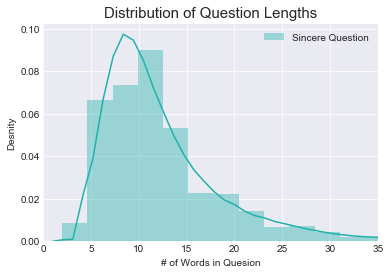

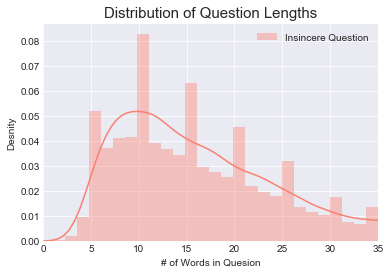

In [19]:
question_lengths_distribution(split_train0, 'Sincere', 'lightseagreen')
question_lengths_distribution(split_train1, 'Insincere', 'salmon')

Insincere questions seem to be longer on average and have a larger variance on their length.  Sincere questions seem to clump up around the 9 word length while insincere have a less pronounced peek at around 10 words. 

When an individual is hoping to assert an opinon, it generally takes more words to do this than asking a question. We noticed that among insincere questions, users were often attempting to state an opinon or make discriminatory remarks about a group. Perhaps, this is why we see the above observation.

#### Outliers

In [20]:
# Sincere
sincere_outlier = split_train0[489956]
print 'Longest Sincere Question is: ' + str(len(sincere_outlier)) + ' words\n'
sentence = ""
for word in split_train0[489956]:
     sentence = sentence + word + " " 
print sentence

Longest Sincere Question is: 134 words

in "star trek 2013" why did they : *spoilers* *spoilers* *spoilers* *spoilers* 1)make warping look quite a bit like an hyperspace jump 2)what in the world were those bright particles as soon as they jumped. 3)why in the world did they make it possible for two entities to react in warp space in separate jumps. 4)why did spock get emotions for this movie. 5)what was the point of hiding the "enterprise" underwater. 6)when they were intercepted by the dark ship, how come they reached earth when they were far away from her.(i don't seem to remember the scene where they warp to earth). 7)how did the ship enter earth's atmosphere when it wasnt even in orbit. 8)when scotty opened the door of the black ship , how come pike and khan didn't slow down? 


There is an outlier for question length in the Sincere Question group.  This question is 134 words long and this user asked 7 questions in one post which resulted in the long length.

In [21]:
# Insincere
question_lengths = [len(q) for q in split_train1]
print 'The longest insincere question is: ' + str(sorted(question_lengths)[80809]) + ' words'

The longest insincere question is: 64 words


Outliers do not seem significant in insincere questions. The longest question length for this type is roughly half as long as the longest sincere question outlier.

### Plot Common Word Frequencies

In [22]:
concatenated_split_train1 = list(itertools.chain.from_iterable(split_train1))
concatenated_split_train0 = list(itertools.chain.from_iterable(split_train0))
s = stopwords.words('english')
concatenated_split_train1 = list(filter(lambda x : x not in s, concatenated_split_train1))  # filter out all stop words (e.g. pronouns, articles)
concatenated_split_train0 = list(filter(lambda x : x not in s, concatenated_split_train0))

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  """


In [23]:
def common_word_freq(concatenated_split_train, q_type, c):
    top = pd.Series(concatenated_split_train).value_counts()[:40] # top 40 words 
    plt.figure(figsize=(15,15))
    plt.title("Top 40 Most Frequent Words - " + q_type + " Questions", fontsize = 20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=15)
    plt.ylabel('Word', fontsize = 17)
    plt.xlabel('Count', fontsize = 17)
    top.plot(kind='barh', color = c)
    plt.show()

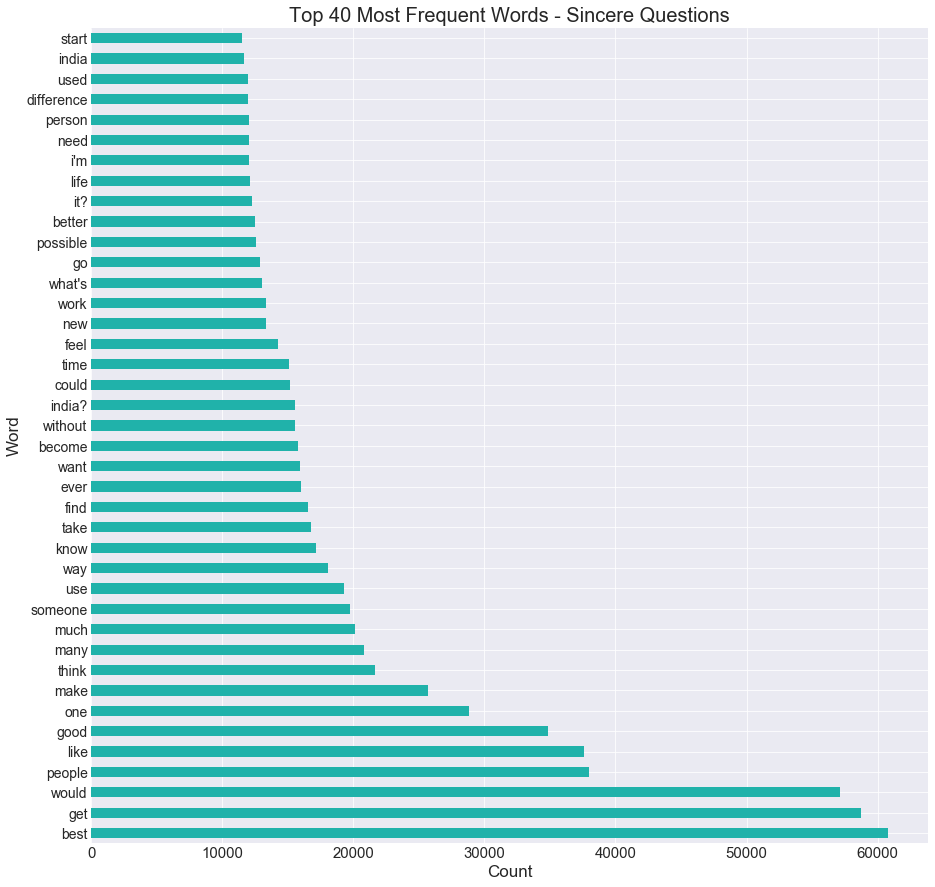

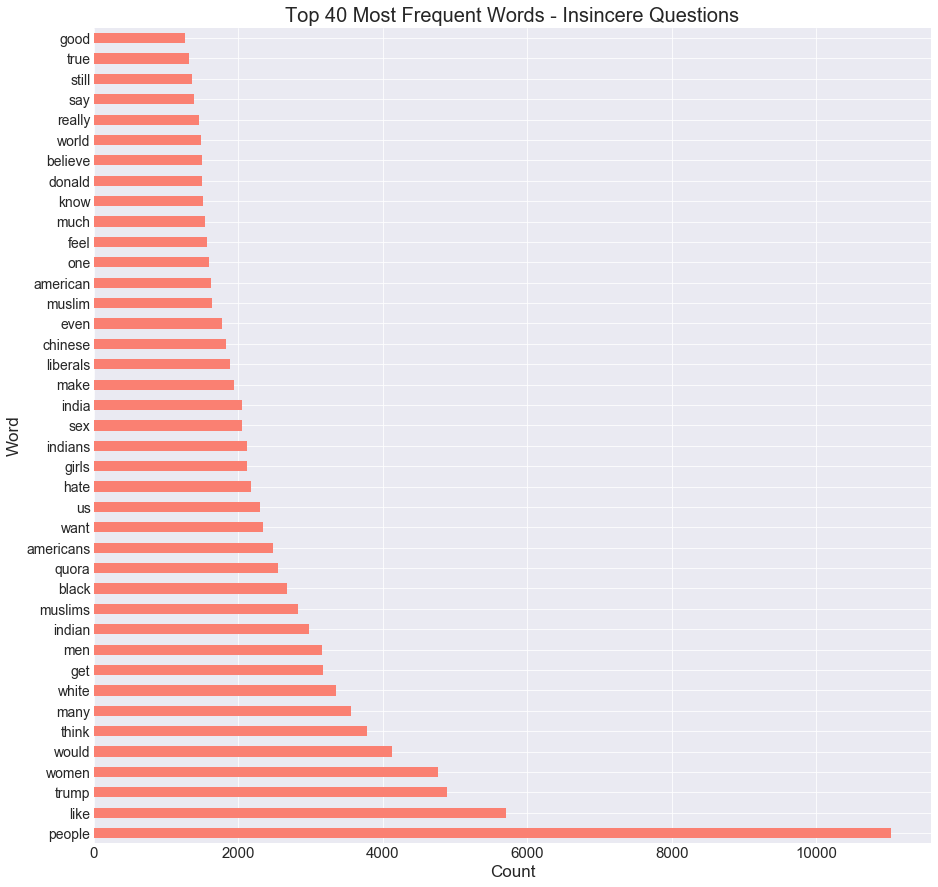

In [24]:
common_word_freq(concatenated_split_train0, 'Sincere', 'lightseagreen')
common_word_freq(concatenated_split_train1, 'Insincere', 'salmon')

## Word Cloud
Below are word clouds for sincere and insincere documents.

In [25]:
def display_wordcloud(concatenated_split_train):
    unique_string=(" ").join(concatenated_split_train)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#### Sincere

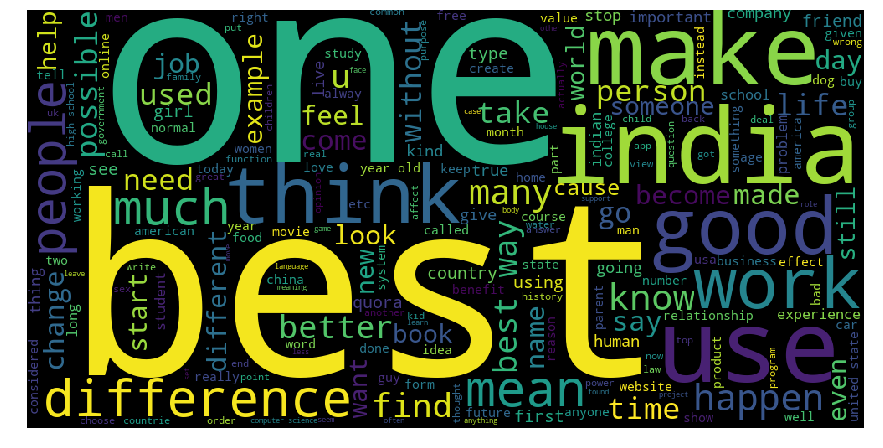

In [26]:
display_wordcloud(concatenated_split_train0)

#### Insincere 

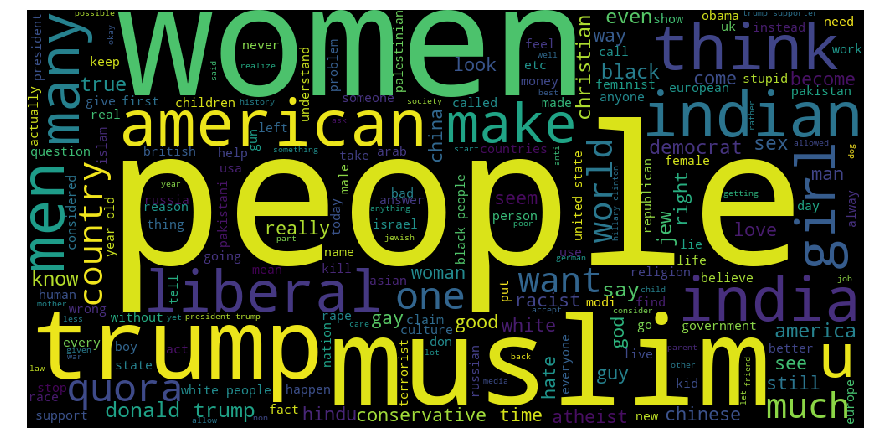

In [27]:
display_wordcloud(concatenated_split_train1)

A picture is worth a thousand words:)

### Bigram/Trigram Plots
The plots for top bigrams/trigrams in insincere questions can help us determine what kind of questions Quora would like to limit or ban. People are always finding creative new ways to ask insincere questions, and it is important for Quora to be aware of any new forms of insincere questions so as to make changes to its policies and guidelines if need be. The top bigram/trigram plots are one way to group insincere questions in a more intelligible format by pinpointing frequent topics of insincere questions.

There are many potential uses for such findings including this non-exhaustive list:

   * They can be examined repeatedly to regularly refine Quora's definition of an insincere question.
   
   * They can give insight into the level of racism, sexism, and other discrimantory thoughts that are prevalent in the world. Note that although the group of users on Quora is a sample of the popultaion of the world, the approximation for population   parameters is not necessarily wholistic since the set of all Quora questions is a nonrandom sample. Nonetheless, if our goal is to limit all forms of existing discriminatory thoughts, then using Quora for such an agenda is a step in our intended direction.
   * Given that questions on Quora can be written anonymously, a grouping of the most frequent topics in anonymously proposed insincere questions can illustrate what some of our deepest and/or darkest thoughts are. This demonstrates that anonymity is a key factor to confession since we are often hestitant towards admitting dishonorable thoughts.

In [29]:
# Bigrams for insincere questions    
bigram_ins = nltk.bigrams(concatenated_split_train1)
fdist_ins = nltk.FreqDist(bigram_ins)

# Bigrams for sincere questions    
bigram_sin = nltk.bigrams(concatenated_split_train0)
fdist_sin = nltk.FreqDist(bigram_sin)

# Trigrams for insincere questions
trigram_ins = nltk.ngrams(concatenated_split_train1, 3)
fdist2_ins = nltk.FreqDist(trigram_ins)

# Trigrams for sincere questions
trigram_sin = nltk.ngrams(concatenated_split_train0, 3)
fdist2_sin = nltk.FreqDist(trigram_sin)

In [43]:
def plot_n_grams(f, q_type, ngram, val, col):
    f = {key:value for key, value in f.items() if value >= val }
    top_ngm = pd.Series(f)
    top_ngm = top_ngm.sort_values()
    plt.figure(figsize=(10, 10))
    plt.title("Top 40 " + ngram + "s for " + q_type + " Questions", fontsize = 20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=15)
    plt.ylabel(ngram, fontsize = 17)
    plt.xlabel('Count', fontsize = 17)
    top_ngm.plot(kind = 'barh', color = col)
    plt.show()

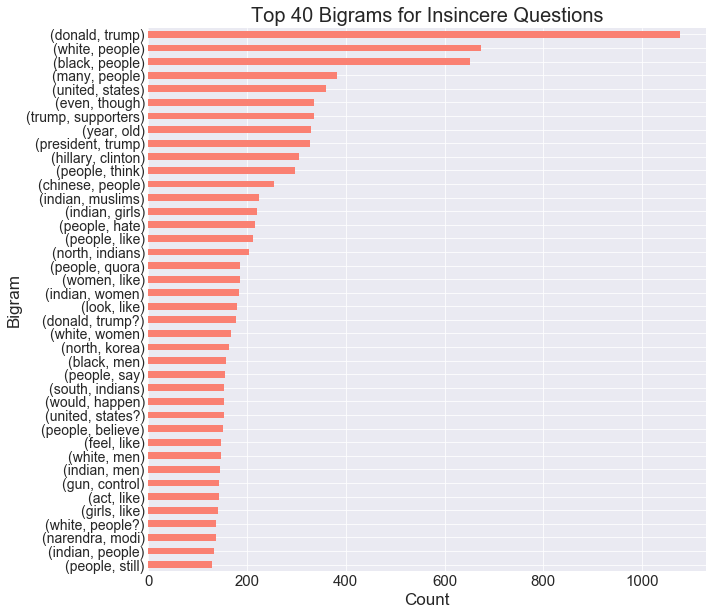

In [45]:
plot_n_grams(fdist_ins, 'Insincere', 'Bigram', 130, 'Salmon')

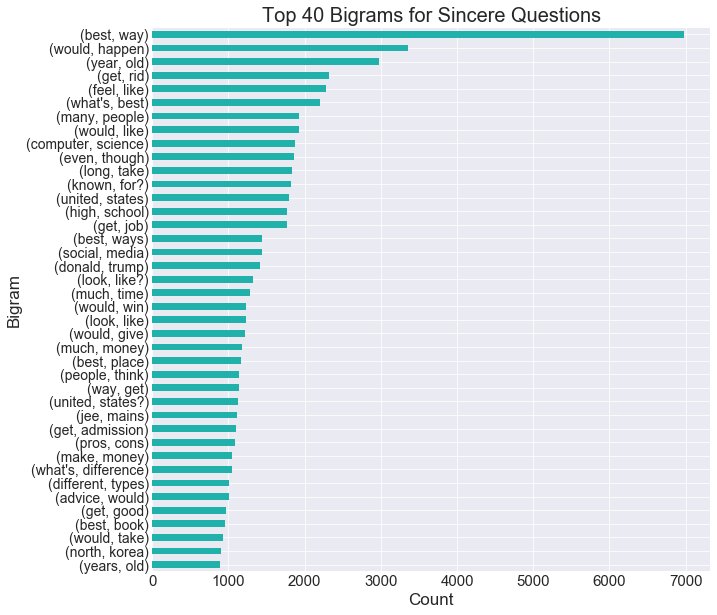

In [46]:
plot_n_grams(fdist_sin, 'Sincere', 'Bigram', 888, 'lightseagreen')

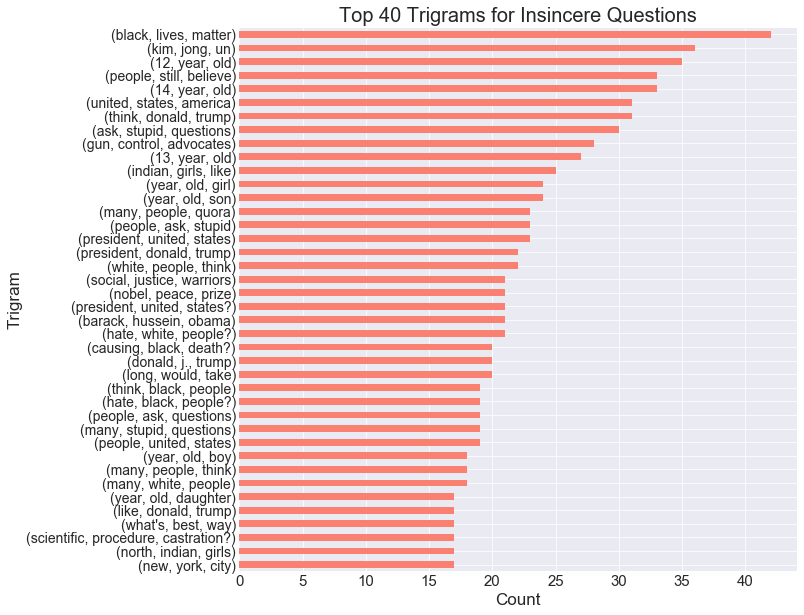

In [44]:
plot_n_grams(fdist2_ins, 'Insincere', 'Trigram', 17, 'Salmon')

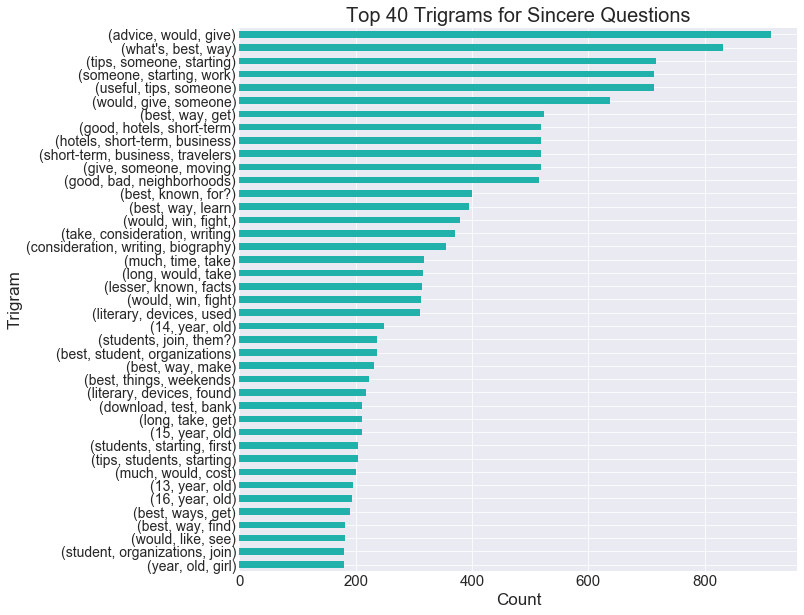

In [50]:
plot_n_grams(fdist2_sin, 'Sincere', 'Trigram', 180, 'lightseagreen')

## Data Modeling

#### Create Features for Training/Testing Data
Our input values will be constructed as follows:
* Features = columns
* Samples = rows

Let's concatenate the questions from the training data and testing data so that we can create the features based on the entire dataset. If we were to do this for the training and testing datasets individually, this would cause errors when we try to predict values from our testing dataset due to different number of dimensions in the number of columns in train compared to test data.

In [52]:
def get_data(x_train, x_test, y_train):
    x = copy.deepcopy(x_train)
    z = copy.deepcopy(x_test)
    y = copy.deepcopy(y_train)
    x = x.append(z)
    x = x.reset_index(drop = True)
    x = np.array(list(map(lambda a: a.lower(), x)))# convert all the values to lowercase so that the stopwords can be filtered better
    return x, y, z

In [53]:
X, Y, Z = get_data(original_train['question_text'], original_test['question_text'], original_train['target'])

In [54]:
X.shape # total samples (includes training and testing samples)

(1362492L,)

In [55]:
print len(Z) # length of test dataset
print float(len(Z))/len(X) # proportion of the entire dataset that is testing data

56370
0.0413727199866


In [56]:
 # proportion of the dataset that is training data
valid_size = len(X) - len(Z)
print float(valid_size)/len(X)

0.958627280013


#### Now, create features through word counts

In [57]:
# gets word counts of all unique words in the dataset - Bag of Words Representation (order doesn't matter)
count_vect = CountVectorizer(stop_words = 'english') # remove stop_words (e.g. the, a, in, pronouns, etc.)
X_train_counts = count_vect.fit_transform(X)

In [58]:
print X[5]
print X_train_counts[5]
print X_train_counts.shape

is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?
  (0, 131520)	1
  (0, 180661)	1
  (0, 49324)	1
  (0, 21690)	1
  (0, 163923)	1
  (0, 74503)	1
(1362492, 199138)


#### TF-IDF (term frequency- inverse document frequency)
* f = frequency of the word in the sample question
* t = total number of documents
* n = number of documents the word is present in
* TF-IDF value = f * log(t/n)

For each question, the TF-IDF vector has TF-IDF value for each word among all the documents. This means there will be many 0s in the entries of the sample since several words will not be present in a given question. 

In [59]:
# most of the tf-idf values in this dataset are less than 1, but it's possible for them to exceed 1
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape # the shape here is the (num_samples, num_features) where num_features == unique words

(1362492, 199138)

In [60]:
X[5] # initial format of question

'is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?'

In [61]:
samp = X_train_tfidf[5].todense() # 1 sample - the question converted into a vector of counts and then a vector of word frequencies
print samp # sample
print samp[samp != 0.0][0,:] # let's see some of the non-zero values in the sample
print samp.shape # shape of the sample

[[0. 0. 0. ... 0. 0. 0.]]
[[0.41783408 0.47241485 0.37168327 0.3099009  0.32646986 0.51134069]]
(1L, 199138L)


After seeing the results of the common word plots above, we noticed that there were stark differences between the insincere and sincere plots. So we decided to choose word counts and TF-IDF representation as two transformations of the questions because we thought that they would be effective at recognizing patterns in insincere and sincere questions. 

### Cross Validation
Let's evaluate the performance of our algorithm here based on this resampling procedure. Then we will use all of our available data to train on for our final algorithm. Since we are using all available training data, the scores from the cross validation will give us an idea of how our finalized model will perform in general. 

#### Model Selection:
- Initially we started with a MultinomialNB clasifier - it has been used on text classification problems by others and it had a  fast run time
- As our base model, we set all the target values equal to the majority class
- This resulted in high accuracy, but zero precision and recall as expected
- We then used all of the observed target values for which we got a high but lower accuracy score than the base model, low precision, and low recall 
- We then realized that a BernoulliNB classifier would be more suitible for our data since the bernoulli distribution describes our data better (this is a binary classification problem)
- From here, we thought we'd explore a support vector machine since it is a generally high performing classifier for various prediction problems
- Finally, we used a linear SVC, which initially didn't perform that well (low recall, high precision); however, we took into account  that the low recall was in part due to the imbalanced nature of the dataset
- So we decided to add a high penalty for misclassifying the minority class through class weights
- This meant that we would have a high class weight (penalty) for the minority class and the opposite for the complement class

In [63]:
scorer = ['accuracy', 'precision', 'recall', 'f1']
algorithm = LinearSVC(class_weight = {0: .2, 1: .8}) # class weights - add a high penalty for missclassifying the minority class
num_splits = 10
cv_results_actual = cross_validate(algorithm, X_train_tfidf[:len(X) - len(Z)], Y, scoring = ('accuracy', 'precision', 'recall', 'f1'), cv = num_splits, return_train_score = True)

In [64]:
# This function shows how well the procedure performs on average
def show_avg_scores(cv_results, n_splits):
    print "Accuracy: " + str(np.mean(cv_results['test_accuracy']))
    print "Precision: " + str(np.mean(cv_results['test_precision']))
    print "Recall: " + str(np.mean(cv_results['test_recall']))
    print "Harmonic Mean: " + str(np.mean(cv_results['test_f1']))

In [65]:
# this function shows how much we expect the performance of the model to vary
def show_std_scores(cv_results, n_splits):
    print "Accuracy: " + str(np.std(cv_results['test_accuracy']))
    print "Precision: " + str(np.std(cv_results['test_precision']))
    print "Recall: " + str(np.std(cv_results['test_recall']))
    print "Harmonic Mean: " + str(np.std(cv_results['test_f1']))

In [66]:
show_avg_scores(cv_results_actual, num_splits)

Accuracy: 0.9430987302286304
Precision: 0.5309245198764927
Recall: 0.6896299962875883
Harmonic Mean: 0.5999561603750352


####  Comment:
* The precision is okay, but could be better. The model is overestimating the amount of insincere questions.
* The recall is fair, but could be better. The model is missing questions that are insincere. 
* The accuracy is not the best metric to use for an imbalanced dataset, but let's still output the score.

Note: We make further remarks on these metrics later on.

In [67]:
show_std_scores(cv_results_actual, num_splits)

Accuracy: 0.0005137235290098857
Precision: 0.003275430055434313
Recall: 0.003104769124604941
Harmonic Mean: 0.0030149982971205583


Above you can see that the spread is relatively low (close to zero), so we conclude that our model performance will be fairly consistent.

### Let's try something...
How can we compare the model performance to a simpler method in which we search for common words?

In [68]:
top_insincere_words = pd.Series(concatenated_split_train1).value_counts()

In [69]:
searches = list(top_insincere_words.index[:100])
insincere_questions = []
sincere_questions = []
for sublist in split_train1:
    if set(sublist) & set(searches):
        insincere_questions.append(sublist)
for sublist in split_train0:
    if set(sublist) & set(searches):
        sincere_questions.append(sublist)
print "Insincere:" + str(len(insincere_questions)/num_insincere)
print "Sincere:" + str(len(sincere_questions)/num_sincere)

Insincere:0.818029946789
Sincere:0.490993314356


Ideally we want the insincere score above to be as close to 1 as possible, and we want the sincere score to be as close to zero as possible
* this means high recall - the model is able to identify all the existing insincere questions
* and high precision - the model is not oversestimating the amount of insincere questions

From the above results, we can see that determining if a question has any words which are typically used in insincere questions is a fairly good way of identifying insincere questions. However, it does have a high error in misidentifying sincere questions as insincere.

### Finalized Model 
#### Linear SVC

In [72]:
def model(alg, x, y, validation_size):
    classifier = alg.fit(x[:validation_size], y)
    predicted = classifier.predict(x[validation_size:])
    return predicted

In [73]:
algorithm = LinearSVC(class_weight = {0: .2, 1: .8}) # add a high penalty for missclassifying the minority class
y_pred = model(algorithm, X_train_tfidf, Y, valid_size)

In [74]:
# percent of final testing data which is insincere - this percentage closely mirrors that of the training sample for insincere questions
float(len(y_pred[y_pred != 0]))/ len(y_pred)

0.0797232570516232

In [75]:
len(y_pred)

56370

Our testing data has no target values, so we cannot evaluate our predictions directly. Again, we evaluate the performance of our solution through cross validation scores. These scores show us how our design will perform in general, so we have an approximation for the results in our finalized model. Nonetheless, we can display some of the predicted samples and make our own judgements. See below.

In [76]:
def display_samples(i, x, valid_size, y):
    print x[valid_size + i]
    print y[i]

In [77]:
# these are the indices of the testing dataset, Z, that were predicted to be insincere
insincere_predicted_indices = list(np.where(y_pred != 0)[0])
sincere_predicted_indices = list(np.where(y_pred == 0)[0])

In [78]:
# display a predicted target value (1 == insincere) with its corresponding sample question
for i in range(5):
    display_samples(insincere_predicted_indices[i], X, valid_size, y_pred)

why don't india start a war with pakistan ? they kill our soldiers.
1
are the bjp bhakts satisfied that prices of petrol and diesel were slashed by 1 paisa? do you think criticizing this would be unpatriotic?
1
do you have any experience with gay people?
1
why do i try to keep my husband happy when he is cheating on me? should i leave or just cheat on him also?
1
are hindus allowed to build new temples in pakistan?
1


In [79]:
# display a predicted target value (0 == sincere) with its corresponding sample question
for i in range(5):
    display_samples(sincere_predicted_indices[i], X, valid_size, y_pred)

my voice range is a2-c5. my chest voice goes up to f4. included sample in my higher chest range. what is my voice type?
0
how much does a tutor earn in bangalore?
0
what are the best made pocket knives under $200-300?
0
why would they add a hypothetical scenario that’s impossible to happen in the link below? it shows what 800 meters rise in sea level would look like.
0
what is the dresscode for techmahindra freshers?
0


In evaluating our results, we found that our algorithm is better than average at identifying insincere questions (69% recall - from cross validation) and it is slightly above average at not overestimating the amount of insincere questions (53% precision - from cross validation). A harmonic average of these two findings shows that our algorithm classifies questions as insincere/sincere better than average (.6 F1 score - from cross validation). We significantly improved our F1 score from our inital model, which produced an F1 score of about .51. The top scores on Kaggle were generally around .69, so you can see that creating a high performing predictive model for this dataset is challenging. The main constraint is the imbalanced nature of the data (93.2% sincere questions and 6.8% insincere questions).

Lastly, after cross validating our dataset, taking a standard deviation of each of the scores produced from different data splits, we found that the standard deviation for recall scores, precision scores and f1 scores was close to zero for all three of these metrics, meaning the performance of our algorithm is relatively consistent. 


### Conclusion
The vast majority of questions on Quora are sincere, and its success as a platform for the dissemination of knowledge depends on positive discussion. We saw that approximately 6.2% of the questions in the dataset were insincere, and as stated the actual amount of insincere questions on Quora are lower. We also saw, based on the bigrams and trigrams, that much of the insincere questions are based on current hot-topic political issues which are bound to evolve over time. Therefore, there is no standard distinguishing feature of an insincere question at least in terms of its content. The bigrams/trigrams also show the volatile nature of political discourse and it would be interesting to see if, over time, insincere questions still revolve around politics. 

It is also important to note that most of the insincere questions were explicitly insincere. For example, “Which races have the smallest penis?” is definitively insincere. However, questions such as “What is 2+2= ?” are not necessarily insincere but would be considered troll or insincere questions. Another interesting feature of insincere questions was the use of “Why”, with the vast majority of insincere questions beginning with “Why”. The usage of “Why” presumes the premise of the question to be true, and often is the result of a desrire to confirm one's beliefs by seeking out an explanation. This shows that people asking insincere questions may have pre-existing beliefs for which they are simply seeking validation, as opposed to asking for differing viewpoints which may negate their beliefs. Such a phenomenon is called confirmation bias, and is well researched in psychology. 

While users on Quora have their own biases, we as data scientists should be aware of our own biases as they in turn will affect the technologies we create. We have seen in this file that to create a machine learning model that classifies a document, we have to define what it means to be sincere or insincere. Not everyone agrees. 


#### Link to youtube video:
* https://youtu.be/5Hc86maanLE